In [1]:
import os
import glob
import numpy as np 
import xarray as xr
import pandas as pd
import datetime
from datetime import date, timedelta
import dask
import scipy as scipy
import cftime

# Plotting utils 
import matplotlib
import matplotlib.pyplot as plt 
import matplotlib.patches as patches
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature


In [2]:
# Grabbed from Brian M. to use time midpoints, not end periods
def cesm_correct_time(ds):
    """Given a Dataset, check for time_bnds,
       and use avg(time_bnds) to replace the time coordinate.
       Purpose is to center the timestamp on the averaging inverval.   
       NOTE: ds should have been loaded using `decode_times=False`
    """
    assert 'time_bnds' in ds
    assert 'time' in ds
    correct_time_values = ds['time_bnds'].mean(dim='nbnd')
    # copy any metadata:
    correct_time_values.attrs = ds['time'].attrs
    ds = ds.assign_coords({"time": correct_time_values})
    ds = xr.decode_cf(ds)  # decode to datetime objects
    return ds

def regrid_data(fromthis, tothis, method=1):
    """Regrid data using various different methods"""

    #Import necessary modules:
    import xarray as xr

    if method == 1:
        # kludgy: spatial regridding only, seems like can't automatically deal with time
        if 'time' in fromthis.coords:
            result = [fromthis.isel(time=t).interp_like(tothis) for t,time in enumerate(fromthis['time'])]
            result = xr.concat(result, 'time')
            return result
        else:
            return fromthis.interp_like(tothis)
    elif method == 2:
        newlat = tothis['lat']
        newlon = tothis['lon']
        coords = dict(fromthis.coords)
        coords['lat'] = newlat
        coords['lon'] = newlon
        return fromthis.interp(coords)
    elif method == 3:
        newlat = tothis['lat']
        newlon = tothis['lon']
        ds_out = xr.Dataset({'lat': newlat, 'lon': newlon})
        regridder = xe.Regridder(fromthis, ds_out, 'bilinear')
        return regridder(fromthis)
    elif method==4:
        # geocat
        newlat = tothis['lat']
        newlon = tothis['lon']
        result = geocat.comp.linint2(fromthis, newlon, newlat, False)
        result.name = fromthis.name
        
        return result

def update_leads(x):
    """Converts from time coordinates to lead coordinates.
    I.e., lead days.
    """
    x = x.rename({"time": "lead"})
    x = x.assign_coords(lead=np.arange(x.lead.size).astype(int))
    
    return x

def drop_duplicates_along_all_dims(obj, keep=False):
    deduplicated = obj
    for dim in obj.dims:
        indexes = {dim: ~deduplicated.get_index(dim).duplicated(keep=keep)}
        deduplicated = deduplicated.isel(indexes)
    return deduplicated

In [3]:
import dask
dask.config.set({'logging.distributed': 'error'})

from dask_jobqueue import PBSCluster

# For Casper
cluster = PBSCluster(
    queue="casper",
    walltime="02:00:00",
    account="P93300041",
    memory="4GB",
    resource_spec="select=1:ncpus=1:mem=4GB",
    cores=1,
    processes=1,
)

from dask.distributed import Client

# Connect client to the remote dask workers
client = Client(cluster)
client

cluster.scale(8)
client.wait_for_workers(8)


/glade/u/apps/opt/conda/envs/npl-2024b/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 36999 instead
  warnings.warn(


In [3]:
# from dask.distributed import Client
# client = Client("tcp://128.117.208.179:43615")


In [4]:
client

<Client: 'tcp://128.117.208.179:46557' processes=8 threads=8, memory=29.84 GiB>

In [21]:
client.close()

# Updated code

In [4]:
def get_fcstDS(dataDir, init):
    # init = fcst_init[iFcst]
    filelist = np.sort(glob.glob(dataDir+'*'+init+'_00z_d01_d46*.nc'))

    # Open all ensemble members for a given init.
    ds = xr.open_mfdataset(
        filelist,
        combine="nested",
        parallel=True,
        concat_dim="member",
        preprocess=drop_duplicates_along_all_dims,
        chunks = {"time": -1, "lon": -1, "lat": -1},
        # speeds things up a bit
        coords="minimal",
        compat="override",
    ).rename({"time": "lead"})

    # Derive datetime for initialization based on the string in the filename.
    MON_TO_INT = {
        "jan": 1,
        "feb": 2,
        "mar": 3,
        "apr": 4,
        "may": 5,
        "jun": 6,
        "jul": 7,
        "aug": 8,
        "sep": 9,
        "oct": 10,
        "nov": 11,
        "dec": 12,
    }

    day = init[0:2]
    mon = init[2:5]
    mon = MON_TO_INT[mon]
    year = init[5::]

    # Assign initialization year and member numbers as coordinates.
    ds = ds.assign_coords(
        lead=np.arange(ds.lead.size).astype(int),
        init=cftime.DatetimeNoLeap(int(year), int(mon), int(day)),
        member=np.arange(ds[var].shape[0]) + 1,
#        member=np.arange(5) + 1,
    )

    # Chunk into one chunk. About 100MB per initialization
    # (full globe, all leads, all members)
    ds = ds.chunk({"member": -1})

    return ds


In [5]:
dataDir_tas= '/glade/campaign/cesm/development/cross-wg/S2S/CESM2/S2SHINDCASTS/p1/tas_2m/2015/05/'

fcst_init = ['04may2015',
             '11may2015',
             '18may2015',
            ]
var = 'tas_2m'

ds_tas_0504 = get_fcstDS(dataDir_tas, fcst_init[0])
ds_tas_0511 = get_fcstDS(dataDir_tas, fcst_init[1])
ds_tas_0518 = get_fcstDS(dataDir_tas, fcst_init[2])

In [6]:
dataDir_pr= '/glade/campaign/cesm/development/cross-wg/S2S/CESM2/S2SHINDCASTS/p1/pr_sfc/2015/05/'

fcst_init = ['04may2015',
             '11may2015',
             '18may2015',
            ]
var = 'pr_sfc'

ds_pr_0504 = get_fcstDS(dataDir_pr, fcst_init[0])
ds_pr_0511 = get_fcstDS(dataDir_pr, fcst_init[1])
ds_pr_0518 = get_fcstDS(dataDir_pr, fcst_init[2])

In [7]:
ds_0504 = xr.merge([ds_tas_0504, ds_pr_0504])
ds_0511 = xr.merge([ds_tas_0511, ds_pr_0511])
ds_0518 = xr.merge([ds_tas_0518, ds_pr_0518])


In [8]:
# Read in climo
model = "CESM2"
data = "climatology" #raw or anom or climatology
hinda = xr.open_zarr("/glade/campaign/mmm/c3we/jaye/S2S_zarr/"+model+"."+data+".daily.geospatial.zarr/", consolidated=True).astype('float32')
hinda["lead"] = range(0,46)


In [10]:
hinda['tp'] =  hinda['tp']/86400

In [11]:
## Need to regrid the special test case to match lat/lon in climo... 
climo_0504 = hinda.sel(dayofyear=124)
climo_0511 = hinda.sel(dayofyear=131)
climo_0518 = hinda.sel(dayofyear=138)

regrid_0504  = regrid_data(ds_0504.reindex(lat=list(reversed(ds_0504.lat))), climo_0504, method=1)
regrid_0511  = regrid_data(ds_0511.reindex(lat=list(reversed(ds_0511.lat))), climo_0511, method=1)
regrid_0518  = regrid_data(ds_0518.reindex(lat=list(reversed(ds_0518.lat))), climo_0518, method=1)


In [89]:
# Get anomalies?
anom_t_0504 = regrid_0504['tas_2m'] - climo_0504['t2m']
anom_t_0511 = regrid_0511['tas_2m'] - climo_0511['t2m']
anom_t_0518 = regrid_0518['tas_2m'] - climo_0518['t2m']

anom_p_0504 = regrid_0504['pr_sfc'] - climo_0504['tp']
anom_p_0511 = regrid_0511['pr_sfc'] - climo_0511['tp']
anom_p_0518 = regrid_0518['pr_sfc'] - climo_0518['tp']

In [102]:
## Average over period of interest (05/23 - 05/26)
times_0504 = np.array([anom_t_0504.init.values+timedelta(days=i) for i in range(len(anom_t_0504.lead.values))])
times_0511 = np.array([anom_t_0511.init.values+timedelta(days=i) for i in range(len(anom_t_0511.lead.values))])
times_0518 = np.array([anom_t_0518.init.values+timedelta(days=i) for i in range(len(anom_t_0518.lead.values))])

# anom_t_0504 = anom_t_0504.isel(lead=slice(19,23)).mean(dim='lead')
# anom_t_0511 = anom_t_0511.isel(lead=slice(12,16)).mean(dim='lead')
# anom_t_0518 = anom_t_0518.isel(lead=slice(5,9)).mean(dim='lead')

# anom_p_0504 = anom_p_0504.isel(lead=slice(19,23)).mean(dim='lead')
# anom_p_0511 = anom_p_0511.isel(lead=slice(12,16)).mean(dim='lead')
# anom_p_0518 = anom_p_0518.isel(lead=slice(5,9)).mean(dim='lead')

# # what about 5/24-5/26?
anom_t_0504 = anom_t_0504.isel(lead=slice(20,22)).mean(dim='lead')
anom_t_0511 = anom_t_0511.isel(lead=slice(13,15)).mean(dim='lead')
anom_t_0518 = anom_t_0518.isel(lead=slice(6,8)).mean(dim='lead')

anom_p_0504 = anom_p_0504.isel(lead=slice(20,23)).mean(dim='lead')
anom_p_0511 = anom_p_0511.isel(lead=slice(13,16)).mean(dim='lead')
anom_p_0518 = anom_p_0518.isel(lead=slice(6,9)).mean(dim='lead')


AttributeError: 'DataArray' object has no attribute 'lead'

In [69]:
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')


In [77]:
longrid_anom, latgrid_anom = np.meshgrid(anom_t_0504['lon'], anom_t_0504['lat'] )
normVar_anom_t  = matplotlib.colors.Normalize(vmin=-6, vmax=6)
normVar_anom_p  = matplotlib.colors.Normalize(vmin=-0.8e-4, vmax=0.8e-4)



Text(0.5, 1.0, 'Ensemble Mean Anomalous PR: 5/18 init')

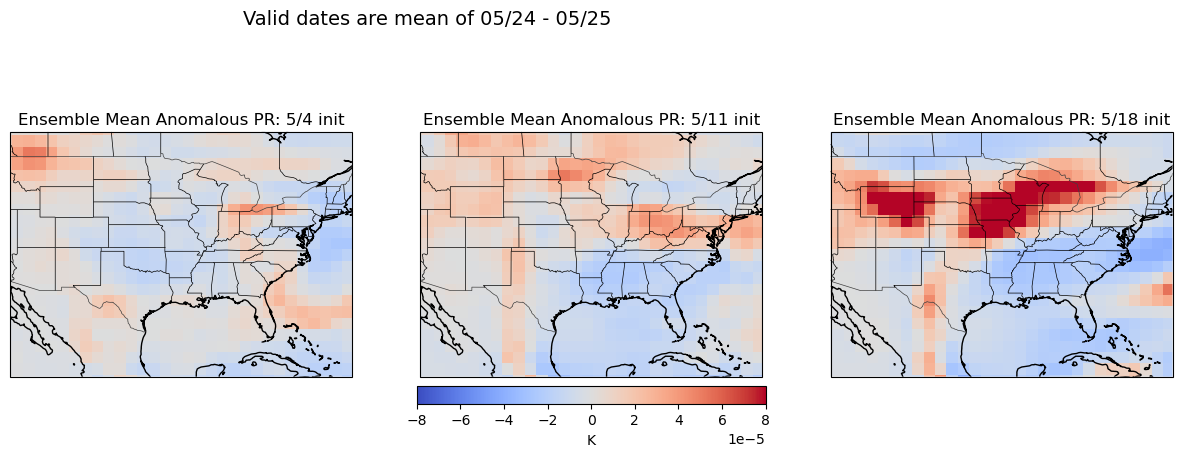

In [92]:
fig,axs = plt.subplots(1,3, figsize=(15,5),subplot_kw={'projection':ccrs.PlateCarree()})
axs     = axs.ravel()

[a.coastlines() for a in axs]
[a.set_extent([245,290,20,50]) for a in axs]
[a.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25') for a in axs]
[a.add_feature(states_provinces,edgecolor='k',linewidth=0.5) for a in axs]

# fig.text(0.28,0.95,'Valid dates are mean of 05/23 - 05/26 ',fontsize=14)
fig.text(0.28,0.95,'Valid dates are mean of 05/24 - 05/25 ',fontsize=14)

# Plot ens mean 
axs[0].pcolormesh(longrid_anom,latgrid_anom, np.squeeze(anom_p_0504.mean(dim='member').values), 
                  cmap='coolwarm', norm=normVar_anom_p, transform=ccrs.PlateCarree())
axs[0].set_title('Ensemble Mean Anomalous PR: 5/4 init')

p1 =axs[1].pcolormesh(longrid_anom,latgrid_anom, np.squeeze(anom_p_0511.mean(dim='member').values), 
                  cmap='coolwarm', norm=normVar_anom_p, transform=ccrs.PlateCarree())
axs[1].set_title('Ensemble Mean Anomalous PR: 5/11 init')
# Add colorbar
cb = fig.colorbar(p1, ax=axs[0:3], shrink=0.3, label='K', orientation='horizontal', pad=0.025) 

axs[2].pcolormesh(longrid_anom,latgrid_anom, np.squeeze(anom_p_0518.mean(dim='member').values), 
                  cmap='coolwarm', norm=normVar_anom_p, transform=ccrs.PlateCarree())
axs[2].set_title('Ensemble Mean Anomalous PR: 5/18 init')


Text(0.5, 1.0, 'Ensemble Mean Anomalous TREFHT: 5/18 init')

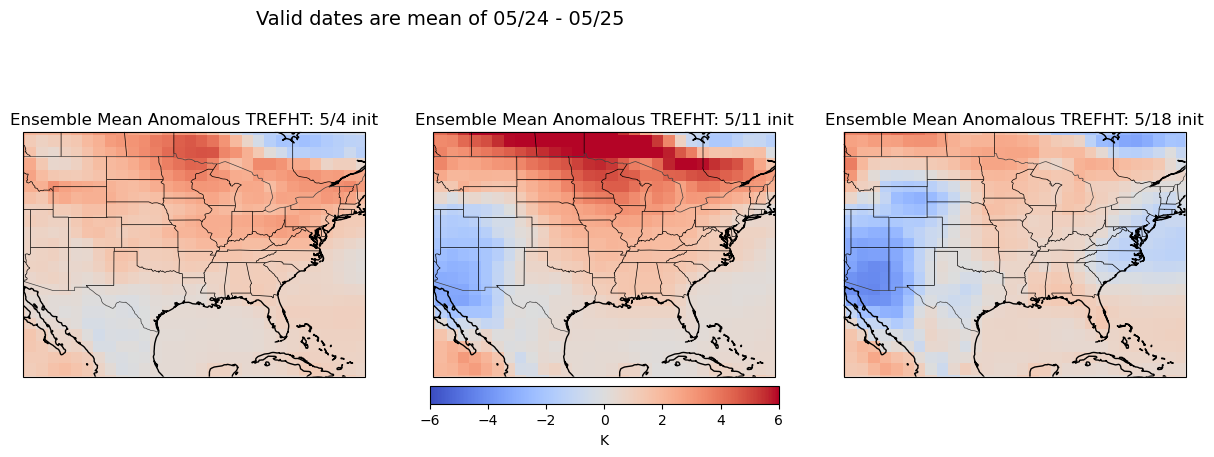

In [93]:
fig,axs = plt.subplots(1,3, figsize=(15,5),subplot_kw={'projection':ccrs.PlateCarree()})
axs     = axs.ravel()

[a.coastlines() for a in axs]
[a.set_extent([245,290,20,50]) for a in axs]
[a.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25') for a in axs]
[a.add_feature(states_provinces,edgecolor='k',linewidth=0.5) for a in axs]

# fig.text(0.28,0.95,'Valid dates are mean of 05/23 - 05/26 ',fontsize=14)
fig.text(0.28,0.95,'Valid dates are mean of 05/24 - 05/25 ',fontsize=14)

# Plot ens mean 
axs[0].pcolormesh(longrid_anom,latgrid_anom, np.squeeze(anom_t_0504.mean(dim='member').values), 
                  cmap='coolwarm', norm=normVar_anom_t, transform=ccrs.PlateCarree())
axs[0].set_title('Ensemble Mean Anomalous TREFHT: 5/4 init')

p1 =axs[1].pcolormesh(longrid_anom,latgrid_anom, np.squeeze(anom_t_0511.mean(dim='member').values), 
                  cmap='coolwarm', norm=normVar_anom_t, transform=ccrs.PlateCarree())
axs[1].set_title('Ensemble Mean Anomalous TREFHT: 5/11 init')
# Add colorbar
cb = fig.colorbar(p1, ax=axs[0:3], shrink=0.3, label='K', orientation='horizontal', pad=0.025) 

axs[2].pcolormesh(longrid_anom,latgrid_anom, np.squeeze(anom_t_0518.mean(dim='member').values), 
                  cmap='coolwarm', norm=normVar_anom_t, transform=ccrs.PlateCarree())
axs[2].set_title('Ensemble Mean Anomalous TREFHT: 5/18 init')


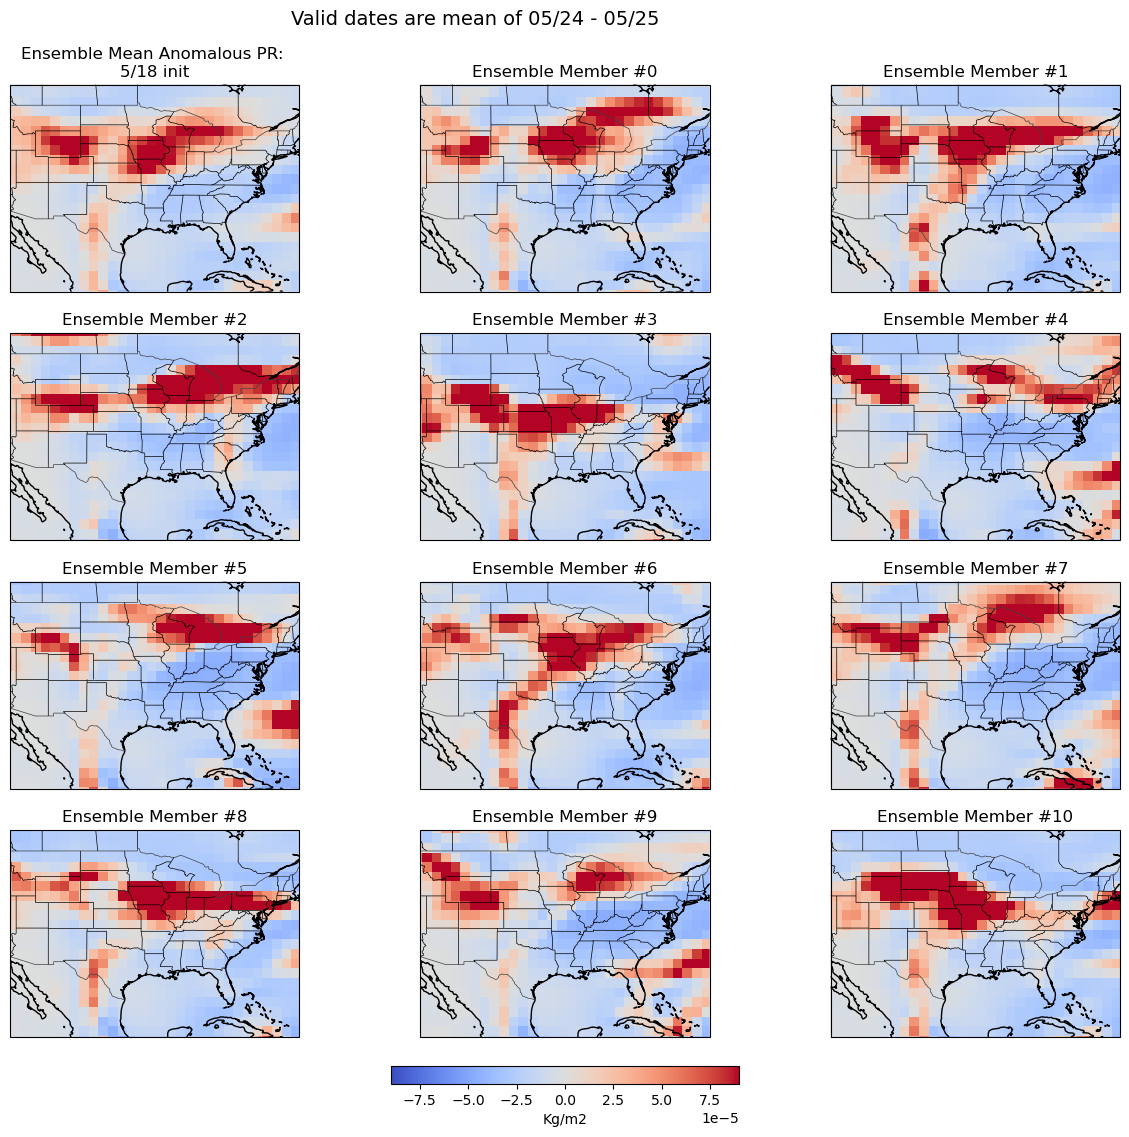

In [101]:
normVar_anom_p  = matplotlib.colors.Normalize(vmin=-0.9e-4, vmax=0.9e-4)


fig,axs = plt.subplots(4,3, figsize=(15,15),subplot_kw={'projection':ccrs.PlateCarree()})
axs     = axs.ravel()

[a.coastlines() for a in axs]
[a.set_extent([245,290,20,50]) for a in axs]
[a.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25') for a in axs]
[a.add_feature(states_provinces,edgecolor='k',linewidth=0.5) for a in axs]

# fig.text(0.28,0.95,'Valid dates are mean of 05/23 - 05/26 ',fontsize=14)
fig.text(0.33,0.92,'Valid dates are mean of 05/24 - 05/25 ',fontsize=14)


for iEns in range(12): 
    if iEns==0:
        axs[0].pcolormesh(longrid_anom,latgrid_anom, np.squeeze(anom_p_0518.mean(dim='member').values), 
                  cmap='coolwarm', norm=normVar_anom_p, transform=ccrs.PlateCarree())
        axs[0].set_title('Ensemble Mean Anomalous PR: \n5/18 init')
    else: 
        p = axs[iEns].pcolormesh(longrid_anom,latgrid_anom, np.squeeze(anom_p_0518.isel(member=(iEns-1)).values), 
                  cmap='coolwarm', norm=normVar_anom_p, transform=ccrs.PlateCarree())
        axs[iEns].set_title('Ensemble Member #'+str(iEns-1))

# Add colorbar
cb = fig.colorbar(p, ax=axs, shrink=0.3, label='Kg/m2', orientation='horizontal', pad=0.025) 
   


# Original code below here

## Get data

In [5]:
def process_lnd(DS):
    keepVars = ['SOILWATER_10CM','RAIN']

    # Select just the initial condition (day 0)
    DS = DS.isel(time=0)
    
    # Select just the specified variable 
    DSproc = DS[keepVars]
    
    return DSproc

In [6]:
dataDir = '/glade/campaign/cesm/development/cross-wg/S2S/CESM2/S2SHINDCASTS/lnd/'

## Also get the full reforecast for June 1 2021 initialization 
listFiles_caseStudy = np.sort(glob.glob(dataDir+'*.clm2.h0.2015-05-04-*.nc'))

for iEns in range(len(listFiles_caseStudy)):
    ensMember = int(listFiles_caseStudy[iEns].split('.')[2])  

    DS = xr.open_dataset(listFiles_caseStudy[iEns])[['SOILWATER_10CM','RAIN']]
    DS = DS.assign_coords({"ens":  iEns})

    if iEns==0:
        caseStudy_0504 = DS
    else:
        caseStudy_0504 = xr.concat([caseStudy_0504, DS], "ens")


## Atm data
dataDir = '/glade/campaign/cesm/development/cross-wg/S2S/CESM2/S2SHINDCASTS/daily/'
listFiles_caseStudy = np.sort(glob.glob(dataDir+'*.cam.h2.2015-05-04-*.nc'))

for iEns in range(len(listFiles_caseStudy)):
    ensMember = int(listFiles_caseStudy[iEns].split('.')[2])  

    DS = xr.open_dataset(listFiles_caseStudy[iEns])
    DS = cesm_correct_time(DS)
    DS = DS.assign_coords({"ens":  iEns})

    if iEns==0:
        caseStudy_0504_atm = DS
    else:
        caseStudy_0504_atm = xr.concat([caseStudy_0504_atm, DS], "ens")
        


In [7]:
dataDir = '/glade/campaign/cesm/development/cross-wg/S2S/CESM2/S2SHINDCASTS/lnd/'

## Also get the full reforecast for June 1 2021 initialization 
listFiles_caseStudy = np.sort(glob.glob(dataDir+'*.clm2.h0.2015-05-11-*.nc'))

for iEns in range(len(listFiles_caseStudy)):
    ensMember = int(listFiles_caseStudy[iEns].split('.')[2])  

    DS = xr.open_dataset(listFiles_caseStudy[iEns])[['SOILWATER_10CM','RAIN']]
    DS = DS.assign_coords({"ens":  iEns})

    if iEns==0:
        caseStudy_0511 = DS
    else:
        caseStudy_0511 = xr.concat([caseStudy_0511, DS], "ens")

## Atm data
dataDir = '/glade/campaign/cesm/development/cross-wg/S2S/CESM2/S2SHINDCASTS/daily/'
listFiles_caseStudy = np.sort(glob.glob(dataDir+'*.cam.h2.2015-05-11-*.nc'))

for iEns in range(len(listFiles_caseStudy)):
    ensMember = int(listFiles_caseStudy[iEns].split('.')[2])  

    DS = xr.open_dataset(listFiles_caseStudy[iEns])
    DS = cesm_correct_time(DS)
    DS = DS.assign_coords({"ens":  iEns})

    if iEns==0:
        caseStudy_0511_atm = DS
    else:
        caseStudy_0511_atm = xr.concat([caseStudy_0511_atm, DS], "ens")
        

In [34]:
dataDir = '/glade/campaign/cesm/development/cross-wg/S2S/CESM2/S2SHINDCASTS/lnd/'

## Also get the full reforecast for June 1 2021 initialization 
listFiles_caseStudy = np.sort(glob.glob(dataDir+'*.clm2.h0.2015-05-18-*.nc'))

for iEns in range(len(listFiles_caseStudy)):
    ensMember = int(listFiles_caseStudy[iEns].split('.')[2])  

    DS = xr.open_dataset(listFiles_caseStudy[iEns])[['SOILWATER_10CM','RAIN']]
    DS = DS.assign_coords({"ens":  iEns})

    if iEns==0:
        caseStudy_0518 = DS
    else:
        caseStudy_0518 = xr.concat([caseStudy_0518, DS], "ens")


## Atm data
dataDir = '/glade/campaign/cesm/development/cross-wg/S2S/CESM2/S2SHINDCASTS/daily/'
listFiles_caseStudy = np.sort(glob.glob(dataDir+'*.cam.h2.2015-05-18-*.nc'))

# for iEns in range(len(listFiles_caseStudy)):
for iEns in range(10):
    ensMember = int(listFiles_caseStudy[iEns].split('.')[2])  

    DS = xr.open_dataset(listFiles_caseStudy[iEns])
    DS = cesm_correct_time(DS)
    DS = DS.assign_coords({"ens":  iEns})

    if iEns==0:
        caseStudy_0518_atm = DS
    else:
        caseStudy_0518_atm = xr.concat([caseStudy_0518_atm, DS], "ens")


In [44]:
caseStudy_0518['time'] = caseStudy_0518_atm['time']


In [37]:
## Get total precipitation (convective + large scale) [m/s]
caseStudy_0504_atm['PRECT'] = caseStudy_0504_atm.PRECC + caseStudy_0504_atm.PRECL
caseStudy_0511_atm['PRECT'] = caseStudy_0511_atm.PRECC + caseStudy_0511_atm.PRECL
caseStudy_0518_atm['PRECT'] = caseStudy_0518_atm.PRECC + caseStudy_0518_atm.PRECL

caseStudy_0504_atm['PRECT_mmday'] = caseStudy_0504_atm['PRECT'] * 86400 * 1e3
caseStudy_0511_atm['PRECT_mmday'] = caseStudy_0511_atm['PRECT'] * 86400 * 1e3
caseStudy_0518_atm['PRECT_mmday'] = caseStudy_0518_atm['PRECT'] * 86400 * 1e3


## Look at rainfall forecast over CONUS

In [10]:
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')


In [11]:
## A few plot options that are a bit more generic 
longrid, latgrid = np.meshgrid(caseStudy_0504_atm['lon'], caseStudy_0504_atm['lat'] )
normVar = matplotlib.colors.Normalize(vmin=0, vmax=8)


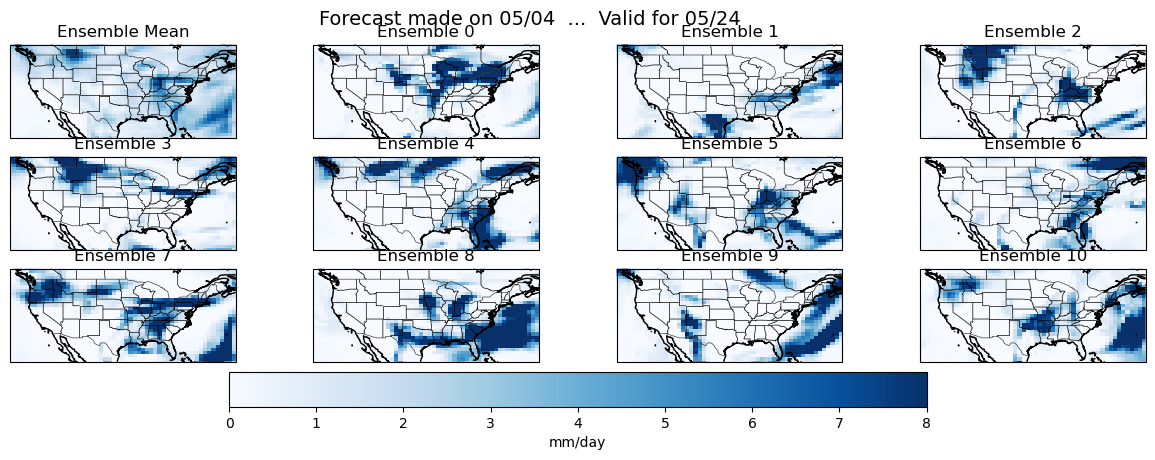

In [12]:
# fig,axs = plt.subplots(2,5, figsize=(20,5), subplot_kw={'projection':ccrs.PlateCarree()})
fig,axs = plt.subplots(3,4, figsize=(15,5), subplot_kw={'projection':ccrs.PlateCarree()})
axs = axs.ravel()

[a.coastlines() for a in axs]
[a.set_extent([230,298,24,47]) for a in axs]
[a.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25') for a in axs]
[a.add_feature(states_provinces,edgecolor='k',linewidth=0.5) for a in axs]

fig.text(0.34,0.92,'Forecast made on 05/04  ...  Valid for 05/24 ',fontsize=14)

# Pick out this time from this forecast 
this_caseStudy = caseStudy_0504_atm.isel(time=np.where(caseStudy_0504_atm['time.day']==24)[0])

# Plot ens mean 
axs[0].pcolormesh(longrid,latgrid, np.squeeze(this_caseStudy.PRECT_mmday.mean(dim='ens').values), 
                  cmap='Blues', norm=normVar, transform=ccrs.PlateCarree())
axs[0].set_title('Ensemble Mean')

# Plot each ens
for iEns in range(len(this_caseStudy.ens.values)):
    p= axs[iEns+1].pcolormesh(longrid,latgrid, np.squeeze(this_caseStudy.PRECT_mmday.isel(ens=iEns).values), 
                  cmap='Blues', norm=normVar, transform=ccrs.PlateCarree())

    axs[iEns+1].set_title('Ensemble '+str(iEns))


# Add colorbar
cb = fig.colorbar(p, ax=axs, shrink=0.6, label='mm/day', orientation='horizontal', pad=0.025) 

plt.show()



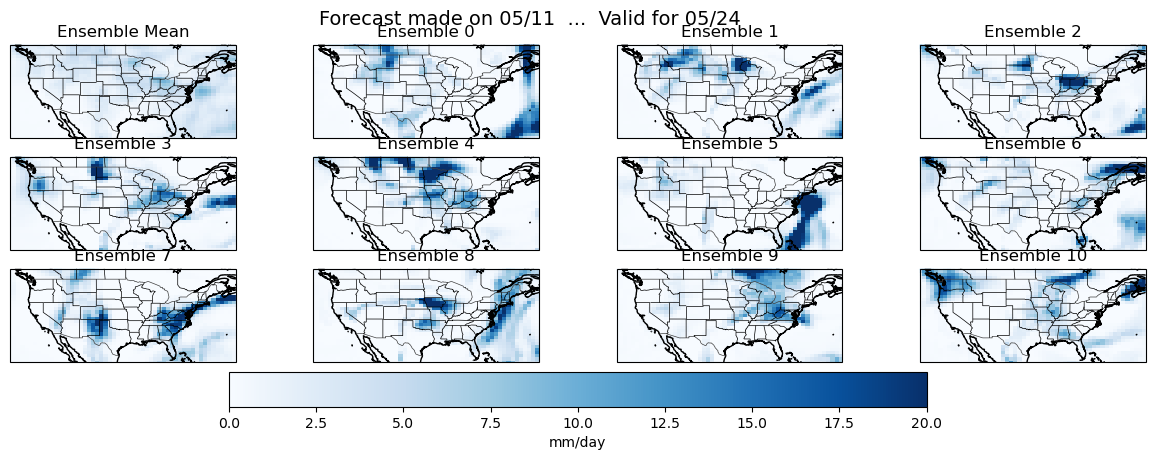

In [172]:
# fig,axs = plt.subplots(2,5, figsize=(20,5), subplot_kw={'projection':ccrs.PlateCarree()})
fig,axs = plt.subplots(3,4, figsize=(15,5), subplot_kw={'projection':ccrs.PlateCarree()})
axs = axs.ravel()

[a.coastlines() for a in axs]
[a.set_extent([230,298,24,47]) for a in axs]
[a.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25') for a in axs]
[a.add_feature(states_provinces,edgecolor='k',linewidth=0.5) for a in axs]

fig.text(0.34,0.92,'Forecast made on 05/11  ...  Valid for 05/24 ',fontsize=14)

# Pick out this time from this forecast 
this_caseStudy = caseStudy_0511_atm.isel(time=np.where( (caseStudy_0511_atm['time.day']==24) & (caseStudy_0511_atm['time.month']==5))[0])

# Plot ens mean 
axs[0].pcolormesh(longrid,latgrid, np.squeeze(this_caseStudy.PRECT_mmday.mean(dim='ens').values), 
                  cmap='Blues', norm=normVar, transform=ccrs.PlateCarree())
axs[0].set_title('Ensemble Mean')

# Plot each ens
for iEns in range(len(this_caseStudy.ens.values)):
    p= axs[iEns+1].pcolormesh(longrid,latgrid, np.squeeze(this_caseStudy.PRECT_mmday.isel(ens=iEns).values), 
                  cmap='Blues', norm=normVar, transform=ccrs.PlateCarree())

    axs[iEns+1].set_title('Ensemble '+str(iEns))


# Add colorbar
cb = fig.colorbar(p, ax=axs, shrink=0.6, label='mm/day', orientation='horizontal', pad=0.025) 

plt.show()



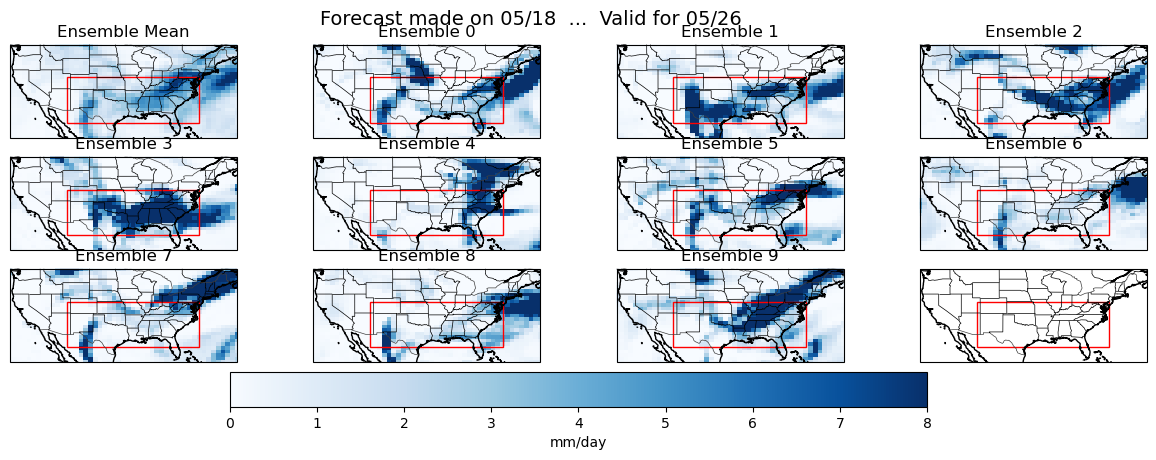

In [36]:
# fig,axs = plt.subplots(2,5, figsize=(20,5), subplot_kw={'projection':ccrs.PlateCarree()})
fig,axs = plt.subplots(3,4, figsize=(15,5), subplot_kw={'projection':ccrs.PlateCarree()})
axs = axs.ravel()

[a.coastlines() for a in axs]
# [a.set_extent([230,298,24,47]) for a in axs]
[a.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25') for a in axs]
[a.add_feature(states_provinces,edgecolor='k',linewidth=0.5) for a in axs]

fig.text(0.34,0.92,'Forecast made on 05/18  ...  Valid for 05/26 ',fontsize=14)

# Pick out this time from this forecast 
this_caseStudy = caseStudy_0518_atm.isel(time=np.where( (caseStudy_0518_atm['time.day']==26) & 
                                                       (caseStudy_0518_atm['time.month']==5))[0])

# Plot ens mean 
axs[0].pcolormesh(longrid,latgrid, np.squeeze(this_caseStudy.PRECT_mmday.mean(dim='ens').values), 
                  cmap='Blues', norm=normVar, transform=ccrs.PlateCarree())
axs[0].set_title('Ensemble Mean')

# Plot each ens
for iEns in range(len(this_caseStudy.ens.values)):
    p= axs[iEns+1].pcolormesh(longrid,latgrid, np.squeeze(this_caseStudy.PRECT_mmday.isel(ens=iEns).values), 
                  cmap='Blues', norm=normVar, transform=ccrs.PlateCarree())

    axs[iEns+1].set_title('Ensemble '+str(iEns))



# Add colorbar
cb = fig.colorbar(p, ax=axs, shrink=0.6, label='mm/day', orientation='horizontal', pad=0.025) 

[a.add_patch(patches.Rectangle(xy=[250, 28], width=(285-250), height=(40-28),
                                facecolor='none', edgecolor='r',linestyle='-',
                                linewidth=1, transform=ccrs.PlateCarree())) for a in axs]
[a.set_extent([235,295,24,45]) for a in axs]


plt.show()



In [ ]:
# -110 to -75

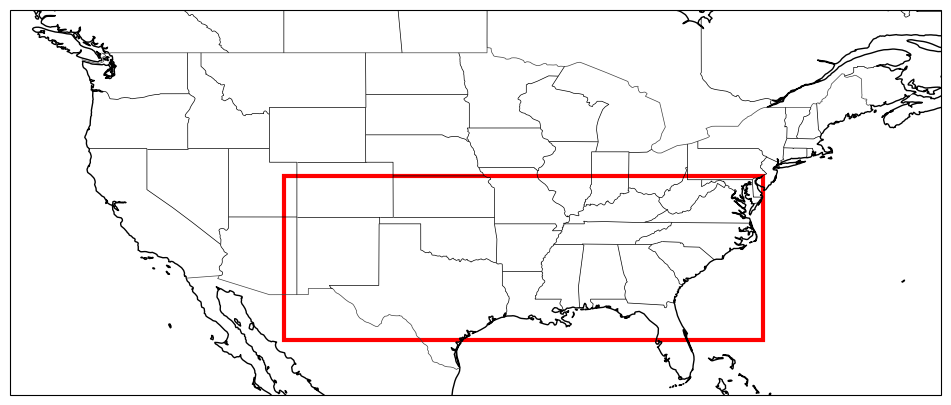

In [33]:
fig,axs = plt.subplots(1,1, figsize=(15,5), subplot_kw={'projection':ccrs.PlateCarree()})

axs.coastlines() 
axs.set_extent([230,298,24,47])
axs.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25') 
axs.add_feature(states_provinces,edgecolor='k',linewidth=0.5) 

axs.add_patch(patches.Rectangle(xy=[250, 28], width=(285-250), height=(40-28),
                                facecolor='none', edgecolor='r',linestyle='-',
                                linewidth=3, transform=ccrs.PlateCarree()))

In [34]:
gpcpFile = '/glade/campaign/cesm/development/cross-wg/S2S/sglanvil/data/pr_sfc_GPCP_19990101-20211231.nc'
obsDS    =  xr.open_dataset(gpcpFile, decode_times=True) 

In [44]:
obsPRECT = obsDS.precip.isel(time=np.where( (obsDS['time.year'].values==2015) & 
                                           (obsDS['time.month'].values==5) & 
                                           (obsDS['time.day'].values==26) )[0])

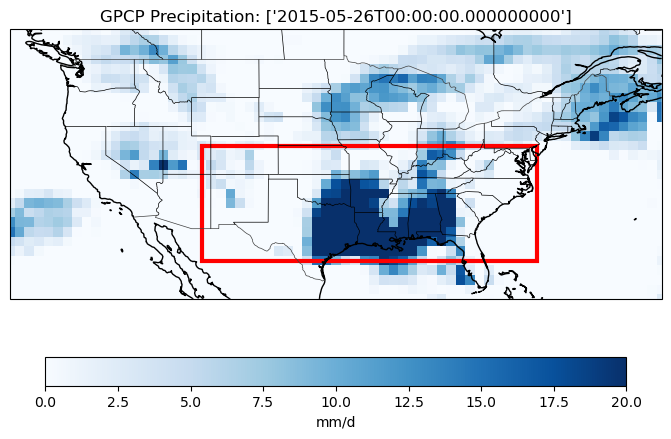

In [45]:
longridObs, latgridObs = np.meshgrid(obsPRECT['longitude'], obsPRECT['latitude'] )
normVar = matplotlib.colors.Normalize(vmin=0, vmax=20)

fig,axs = plt.subplots(1,1, figsize=(15,5), subplot_kw={'projection':ccrs.PlateCarree()})

axs.coastlines() 
axs.set_extent([230,298,24,47])
axs.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25') 
axs.add_feature(states_provinces,edgecolor='k',linewidth=0.5) 

p = axs.pcolormesh(longridObs,latgridObs, np.squeeze(obsPRECT.values), 
                  cmap='Blues', norm=normVar, transform=ccrs.PlateCarree())
axs.set_title('GPCP Precipitation: '+str(obsPRECT.time.values))

fig.colorbar(p, ax=axs, orientation='horizontal',label='mm/d', shrink=0.5)

axs.add_patch(patches.Rectangle(xy=[250, 28], width=(285-250), height=(40-28),
                                facecolor='none', edgecolor='r',linestyle='-',
                                linewidth=3, transform=ccrs.PlateCarree()))

## Look into same days in CLIMO cases

In [27]:
## CLIMO case
dataDir = '/glade/campaign/cesm/development/cross-wg/S2S/CESM2/S2SHINDCASTSclimoALL/archive/'
# listFiles_caseStudy = np.sort(glob.glob(dataDir+'*.cam.h2.2015-05-18-*.nc'))

for iEns in range(10):
    listFiles_caseStudy = np.sort(glob.glob(dataDir+'cesm2cam6climoALL.2015-05-18.0'+str(iEns)+'/atm/hist/*.cam.h2.2015-05-18-*.nc'))[0]
    ensMember = int(listFiles_caseStudy.split('.')[4])  

    DS = xr.open_dataset(listFiles_caseStudy)
    DS = cesm_correct_time(DS)
    DS = DS.assign_coords({"ens":  iEns})

    if iEns==0:
        caseStudy_0518_climoALL = DS
    else:
        caseStudy_0518_climoALL = xr.concat([caseStudy_0518_climoALL, DS], "ens")


caseStudy_0518_climoALL['PRECT']       = caseStudy_0518_climoALL.PRECC + caseStudy_0518_climoALL.PRECL
caseStudy_0518_climoALL['PRECT_mmday'] = caseStudy_0518_climoALL['PRECT'] * 86400 * 1e3


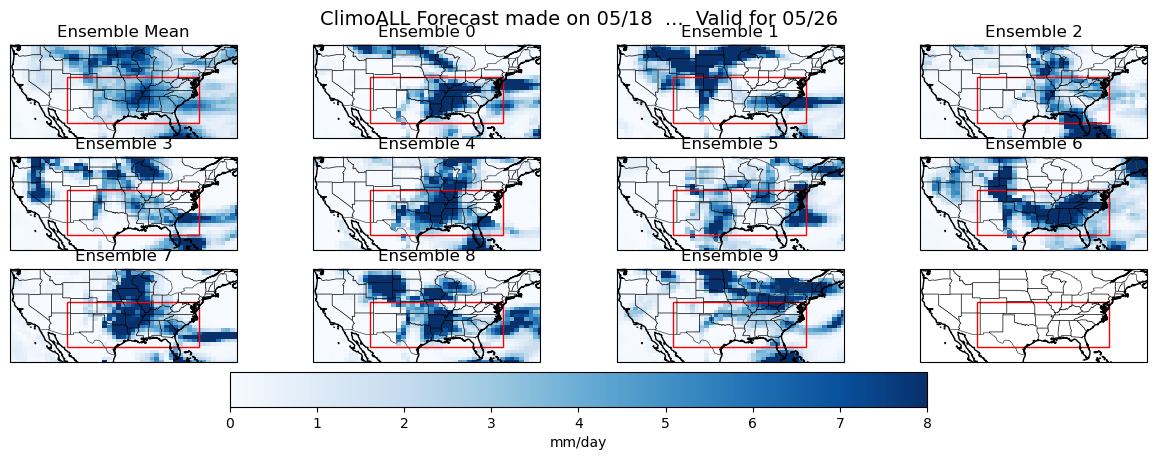

In [33]:
# fig,axs = plt.subplots(2,5, figsize=(20,5), subplot_kw={'projection':ccrs.PlateCarree()})
fig,axs = plt.subplots(3,4, figsize=(15,5), subplot_kw={'projection':ccrs.PlateCarree()})
axs = axs.ravel()

[a.coastlines() for a in axs]
# [a.set_extent([230,298,24,47]) for a in axs]
[a.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25') for a in axs]
[a.add_feature(states_provinces,edgecolor='k',linewidth=0.5) for a in axs]

fig.text(0.34,0.92,'ClimoALL Forecast made on 05/18  ...  Valid for 05/26 ',fontsize=14)

# Pick out this time from this forecast 
this_caseStudy = caseStudy_0518_climoALL.isel(time=np.where( (caseStudy_0518_climoALL['time.day']==26) & 
                                                             (caseStudy_0518_climoALL['time.month']==5))[0])

# Plot ens mean 
axs[0].pcolormesh(longrid,latgrid, np.squeeze(this_caseStudy.PRECT_mmday.mean(dim='ens').values), 
                  cmap='Blues', norm=normVar, transform=ccrs.PlateCarree())
axs[0].set_title('Ensemble Mean')

# Plot each ens
for iEns in range(len(this_caseStudy.ens.values)):
    p= axs[iEns+1].pcolormesh(longrid,latgrid, np.squeeze(this_caseStudy.PRECT_mmday.isel(ens=iEns).values), 
                  cmap='Blues', norm=normVar, transform=ccrs.PlateCarree())

    axs[iEns+1].set_title('Ensemble '+str(iEns))

# Add colorbar
cb = fig.colorbar(p, ax=axs, shrink=0.6, label='mm/day', orientation='horizontal', pad=0.025) 

[a.add_patch(patches.Rectangle(xy=[250, 28], width=(285-250), height=(40-28),
                                facecolor='none', edgecolor='r',linestyle='-',
                                linewidth=1, transform=ccrs.PlateCarree())) for a in axs]
[a.set_extent([235,295,24,45]) for a in axs]


plt.show()



In [38]:
## CLIMO case
dataDir = '/glade/campaign/cesm/development/cross-wg/S2S/CESM2/S2SHINDCASTSclimoATM/archive/'
# listFiles_caseStudy = np.sort(glob.glob(dataDir+'*.cam.h2.2015-05-18-*.nc'))

for iEns in range(10):
    listFiles_caseStudy = np.sort(glob.glob(dataDir+'cesm2cam6climoATM.2015-05-18.0'+str(iEns)+'/atm/hist/*.cam.h2.2015-05-18-*.nc'))[0]
    ensMember = int(listFiles_caseStudy.split('.')[4])  

    DS = xr.open_dataset(listFiles_caseStudy)
    DS = cesm_correct_time(DS)
    DS = DS.assign_coords({"ens":  iEns})

    if iEns==0:
        caseStudy_0518_climoATM = DS
    else:
        caseStudy_0518_climoATM = xr.concat([caseStudy_0518_climoATM, DS], "ens")


caseStudy_0518_climoATM['PRECT']       = caseStudy_0518_climoATM.PRECC + caseStudy_0518_climoATM.PRECL
caseStudy_0518_climoATM['PRECT_mmday'] = caseStudy_0518_climoATM['PRECT'] * 86400 * 1e3


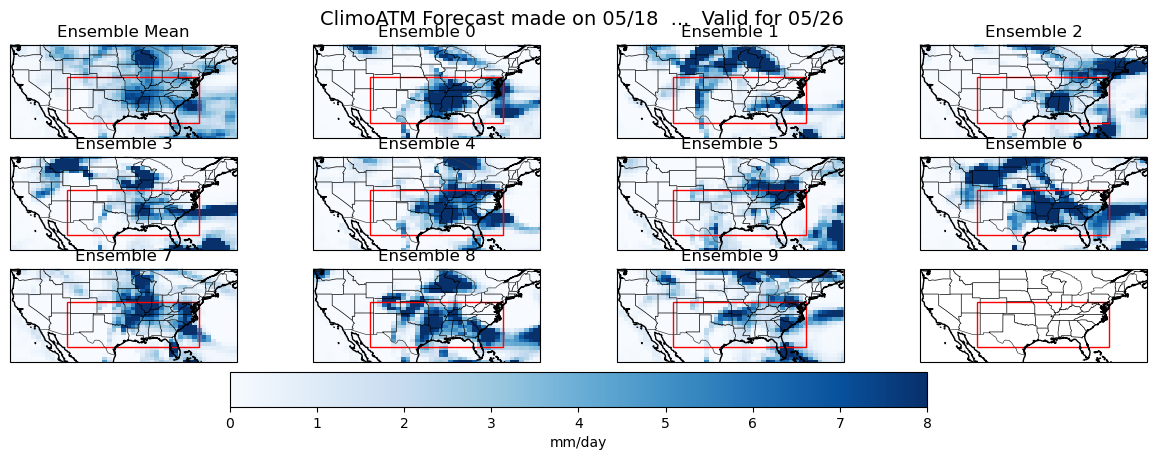

In [40]:
# fig,axs = plt.subplots(2,5, figsize=(20,5), subplot_kw={'projection':ccrs.PlateCarree()})
fig,axs = plt.subplots(3,4, figsize=(15,5), subplot_kw={'projection':ccrs.PlateCarree()})
axs = axs.ravel()

[a.coastlines() for a in axs]
# [a.set_extent([230,298,24,47]) for a in axs]
[a.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25') for a in axs]
[a.add_feature(states_provinces,edgecolor='k',linewidth=0.5) for a in axs]

fig.text(0.34,0.92,'ClimoATM Forecast made on 05/18  ...  Valid for 05/26 ',fontsize=14)

# Pick out this time from this forecast 
this_caseStudy = caseStudy_0518_climoATM.isel(time=np.where( (caseStudy_0518_climoATM['time.day']==26) & 
                                                             (caseStudy_0518_climoATM['time.month']==5))[0])

# Plot ens mean 
axs[0].pcolormesh(longrid,latgrid, np.squeeze(this_caseStudy.PRECT_mmday.mean(dim='ens').values), 
                  cmap='Blues', norm=normVar, transform=ccrs.PlateCarree())
axs[0].set_title('Ensemble Mean')

# Plot each ens
for iEns in range(len(this_caseStudy.ens.values)):
    p= axs[iEns+1].pcolormesh(longrid,latgrid, np.squeeze(this_caseStudy.PRECT_mmday.isel(ens=iEns).values), 
                  cmap='Blues', norm=normVar, transform=ccrs.PlateCarree())

    axs[iEns+1].set_title('Ensemble '+str(iEns))

# Add colorbar
cb = fig.colorbar(p, ax=axs, shrink=0.6, label='mm/day', orientation='horizontal', pad=0.025) 

[a.add_patch(patches.Rectangle(xy=[250, 28], width=(285-250), height=(40-28),
                                facecolor='none', edgecolor='r',linestyle='-',
                                linewidth=1, transform=ccrs.PlateCarree())) for a in axs]
[a.set_extent([235,295,24,45]) for a in axs]


plt.show()



In [39]:
## CLIMO case
dataDir = '/glade/campaign/cesm/development/cross-wg/S2S/CESM2/S2SHINDCASTSclimoLND/archive/'
# listFiles_caseStudy = np.sort(glob.glob(dataDir+'*.cam.h2.2015-05-18-*.nc'))

for iEns in range(10):
    listFiles_caseStudy = np.sort(glob.glob(dataDir+'cesm2cam6climoLND.2015-05-18.0'+str(iEns)+'/atm/hist/*.cam.h2.2015-05-18-*.nc'))[0]
    ensMember = int(listFiles_caseStudy.split('.')[4])  

    DS = xr.open_dataset(listFiles_caseStudy)
    DS = cesm_correct_time(DS)
    DS = DS.assign_coords({"ens":  iEns})

    if iEns==0:
        caseStudy_0518_climoLND = DS
    else:
        caseStudy_0518_climoLND = xr.concat([caseStudy_0518_climoLND, DS], "ens")

caseStudy_0518_climoLND['PRECT']       = caseStudy_0518_climoLND.PRECC + caseStudy_0518_climoLND.PRECL
caseStudy_0518_climoLND['PRECT_mmday'] = caseStudy_0518_climoLND['PRECT'] * 86400 * 1e3


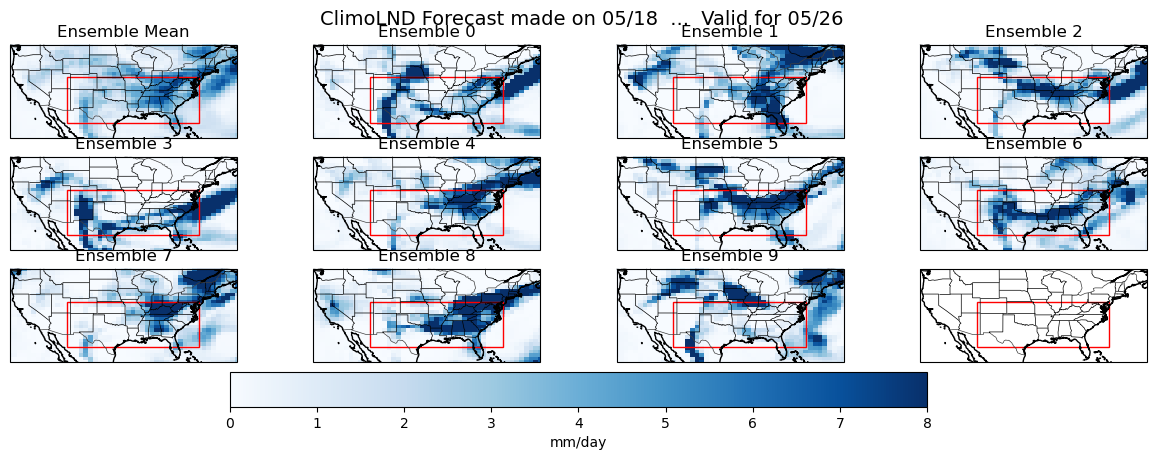

In [41]:
# fig,axs = plt.subplots(2,5, figsize=(20,5), subplot_kw={'projection':ccrs.PlateCarree()})
fig,axs = plt.subplots(3,4, figsize=(15,5), subplot_kw={'projection':ccrs.PlateCarree()})
axs = axs.ravel()

[a.coastlines() for a in axs]
# [a.set_extent([230,298,24,47]) for a in axs]
[a.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25') for a in axs]
[a.add_feature(states_provinces,edgecolor='k',linewidth=0.5) for a in axs]

fig.text(0.34,0.92,'ClimoLND Forecast made on 05/18  ...  Valid for 05/26 ',fontsize=14)

# Pick out this time from this forecast 
this_caseStudy = caseStudy_0518_climoLND.isel(time=np.where( (caseStudy_0518_climoLND['time.day']==26) & 
                                                             (caseStudy_0518_climoLND['time.month']==5))[0])

# Plot ens mean 
axs[0].pcolormesh(longrid,latgrid, np.squeeze(this_caseStudy.PRECT_mmday.mean(dim='ens').values), 
                  cmap='Blues', norm=normVar, transform=ccrs.PlateCarree())
axs[0].set_title('Ensemble Mean')

# Plot each ens
for iEns in range(len(this_caseStudy.ens.values)):
    p= axs[iEns+1].pcolormesh(longrid,latgrid, np.squeeze(this_caseStudy.PRECT_mmday.isel(ens=iEns).values), 
                  cmap='Blues', norm=normVar, transform=ccrs.PlateCarree())

    axs[iEns+1].set_title('Ensemble '+str(iEns))

# Add colorbar
cb = fig.colorbar(p, ax=axs, shrink=0.6, label='mm/day', orientation='horizontal', pad=0.025) 

[a.add_patch(patches.Rectangle(xy=[250, 28], width=(285-250), height=(40-28),
                                facecolor='none', edgecolor='r',linestyle='-',
                                linewidth=1, transform=ccrs.PlateCarree())) for a in axs]
[a.set_extent([235,295,24,45]) for a in axs]


plt.show()



In [42]:
## CLIMO case
dataDir = '/glade/campaign/cesm/development/cross-wg/S2S/CESM2/S2SHINDCASTSclimoOCN/archive/'
# listFiles_caseStudy = np.sort(glob.glob(dataDir+'*.cam.h2.2015-05-18-*.nc'))

for iEns in range(10):
    listFiles_caseStudy = np.sort(glob.glob(dataDir+'cesm2cam6climoOCN.2015-05-18.0'+str(iEns)+'/atm/hist/*.cam.h2.2015-05-18-*.nc'))[0]
    ensMember = int(listFiles_caseStudy.split('.')[4])  

    DS = xr.open_dataset(listFiles_caseStudy)
    DS = cesm_correct_time(DS)
    DS = DS.assign_coords({"ens":  iEns})

    if iEns==0:
        caseStudy_0518_climoOCN = DS
    else:
        caseStudy_0518_climoOCN = xr.concat([caseStudy_0518_climoOCN, DS], "ens")

caseStudy_0518_climoOCN['PRECT']       = caseStudy_0518_climoOCN.PRECC + caseStudy_0518_climoOCN.PRECL
caseStudy_0518_climoOCN['PRECT_mmday'] = caseStudy_0518_climoOCN['PRECT'] * 86400 * 1e3


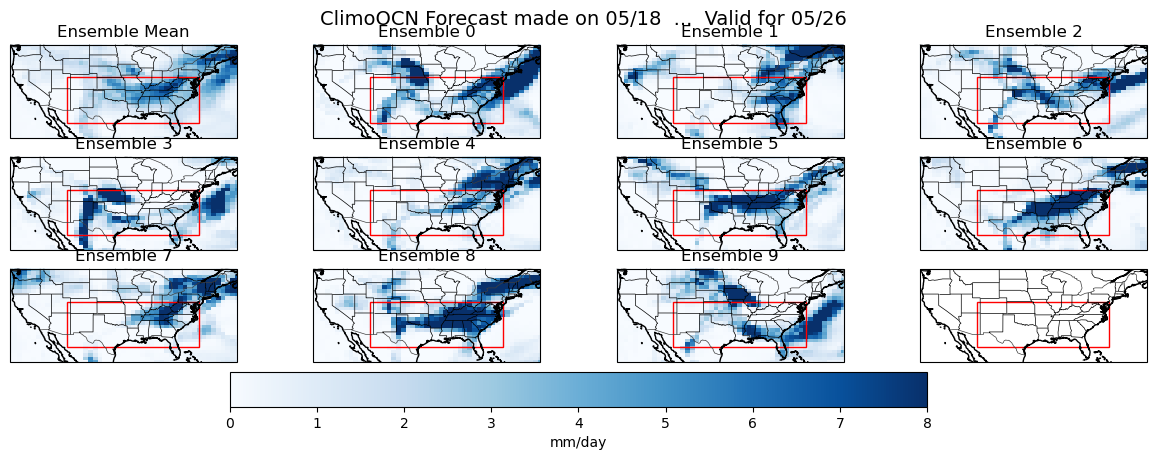

In [43]:
# fig,axs = plt.subplots(2,5, figsize=(20,5), subplot_kw={'projection':ccrs.PlateCarree()})
fig,axs = plt.subplots(3,4, figsize=(15,5), subplot_kw={'projection':ccrs.PlateCarree()})
axs = axs.ravel()

[a.coastlines() for a in axs]
# [a.set_extent([230,298,24,47]) for a in axs]
[a.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25') for a in axs]
[a.add_feature(states_provinces,edgecolor='k',linewidth=0.5) for a in axs]

fig.text(0.34,0.92,'ClimoOCN Forecast made on 05/18  ...  Valid for 05/26 ',fontsize=14)

# Pick out this time from this forecast 
this_caseStudy = caseStudy_0518_climoOCN.isel(time=np.where( (caseStudy_0518_climoOCN['time.day']==26) & 
                                                             (caseStudy_0518_climoOCN['time.month']==5))[0])

# Plot ens mean 
axs[0].pcolormesh(longrid,latgrid, np.squeeze(this_caseStudy.PRECT_mmday.mean(dim='ens').values), 
                  cmap='Blues', norm=normVar, transform=ccrs.PlateCarree())
axs[0].set_title('Ensemble Mean')

# Plot each ens
for iEns in range(len(this_caseStudy.ens.values)):
    p= axs[iEns+1].pcolormesh(longrid,latgrid, np.squeeze(this_caseStudy.PRECT_mmday.isel(ens=iEns).values), 
                  cmap='Blues', norm=normVar, transform=ccrs.PlateCarree())

    axs[iEns+1].set_title('Ensemble '+str(iEns))

# Add colorbar
cb = fig.colorbar(p, ax=axs, shrink=0.6, label='mm/day', orientation='horizontal', pad=0.025) 

[a.add_patch(patches.Rectangle(xy=[250, 28], width=(285-250), height=(40-28),
                                facecolor='none', edgecolor='r',linestyle='-',
                                linewidth=1, transform=ccrs.PlateCarree())) for a in axs]
[a.set_extent([235,295,24,45]) for a in axs]


plt.show()



## Soil conditions?

In [47]:
## A few plot options that are a bit more generic 
longrid, latgrid = np.meshgrid(caseStudy_0504['lon'], caseStudy_0504['lat'] )
normVar = matplotlib.colors.Normalize(vmin=10, vmax=45)


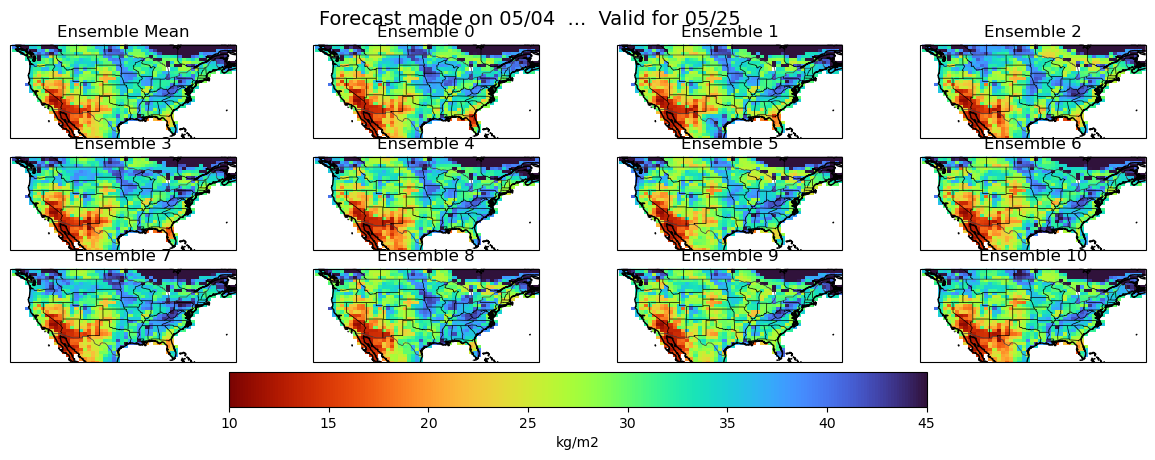

In [121]:
# fig,axs = plt.subplots(2,5, figsize=(20,5), subplot_kw={'projection':ccrs.PlateCarree()})
fig,axs = plt.subplots(3,4, figsize=(15,5), subplot_kw={'projection':ccrs.PlateCarree()})
axs = axs.ravel()

[a.coastlines() for a in axs]
[a.set_extent([230,298,24,47]) for a in axs]
[a.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25') for a in axs]
[a.add_feature(states_provinces,edgecolor='k',linewidth=0.5) for a in axs]

fig.text(0.34,0.92,'Forecast made on 05/04  ...  Valid for 05/25 ',fontsize=14)

# Pick out this time from this forecast 
this_caseStudy = caseStudy_0504.isel(time=np.where(caseStudy_0504['time.day']==25)[0])

# Plot ens mean 
axs[0].pcolormesh(longrid,latgrid, np.squeeze(this_caseStudy.SOILWATER_10CM.mean(dim='ens').values), 
                  cmap='turbo_r', norm=normVar, transform=ccrs.PlateCarree())
axs[0].set_title('Ensemble Mean')

# Plot each ens
for iEns in range(len(this_caseStudy.ens.values)):
    p= axs[iEns+1].pcolormesh(longrid,latgrid, np.squeeze(this_caseStudy.SOILWATER_10CM.isel(ens=iEns).values), 
                  cmap='turbo_r', norm=normVar, transform=ccrs.PlateCarree())

    axs[iEns+1].set_title('Ensemble '+str(iEns))


# Add colorbar
cb = fig.colorbar(p, ax=axs, shrink=0.6, label='kg/m2', orientation='horizontal', pad=0.025) 

plt.show()



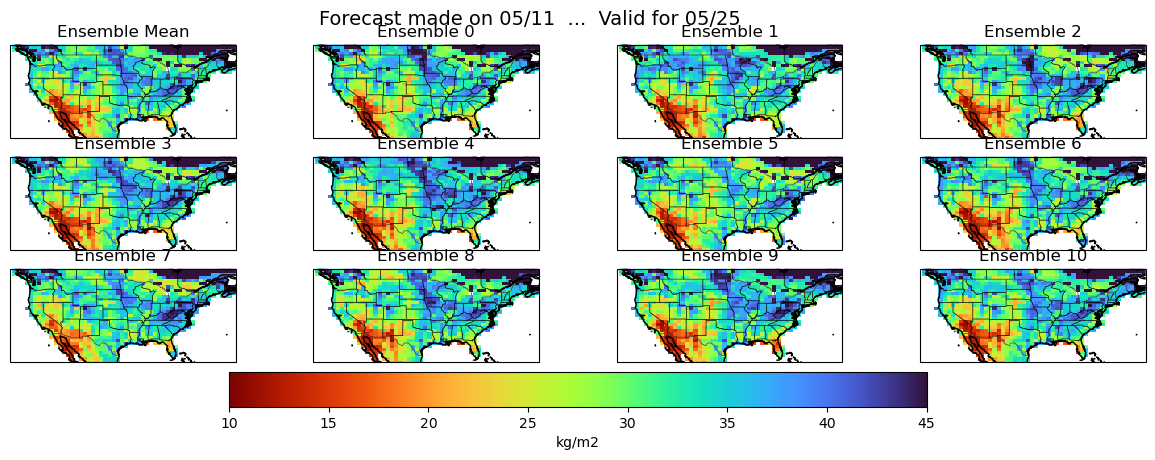

In [122]:
# fig,axs = plt.subplots(2,5, figsize=(20,5), subplot_kw={'projection':ccrs.PlateCarree()})
fig,axs = plt.subplots(3,4, figsize=(15,5), subplot_kw={'projection':ccrs.PlateCarree()})
axs = axs.ravel()

[a.coastlines() for a in axs]
[a.set_extent([230,298,24,47]) for a in axs]
[a.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25') for a in axs]
[a.add_feature(states_provinces,edgecolor='k',linewidth=0.5) for a in axs]

fig.text(0.34,0.92,'Forecast made on 05/11  ...  Valid for 05/25 ',fontsize=14)

# Pick out this time from this forecast 
this_caseStudy = caseStudy_0511.isel(time=np.where( (caseStudy_0511['time.day']==25) & (caseStudy_0511['time.month']==5))[0])

# Plot ens mean 
axs[0].pcolormesh(longrid,latgrid, np.squeeze(this_caseStudy.SOILWATER_10CM.mean(dim='ens').values), 
                  cmap='turbo_r', norm=normVar, transform=ccrs.PlateCarree())
axs[0].set_title('Ensemble Mean')

# Plot each ens
for iEns in range(len(this_caseStudy.ens.values)):
    p= axs[iEns+1].pcolormesh(longrid,latgrid, np.squeeze(this_caseStudy.SOILWATER_10CM.isel(ens=iEns).values), 
                  cmap='turbo_r', norm=normVar, transform=ccrs.PlateCarree())

    axs[iEns+1].set_title('Ensemble '+str(iEns))


# Add colorbar
cb = fig.colorbar(p, ax=axs, shrink=0.6, label='kg/m2', orientation='horizontal', pad=0.025) 

plt.show()



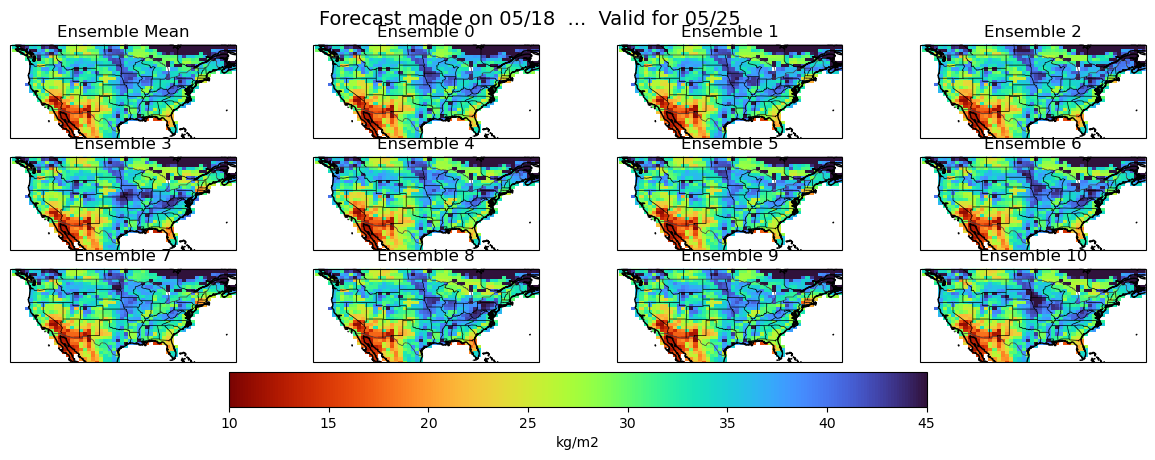

In [49]:
# fig,axs = plt.subplots(2,5, figsize=(20,5), subplot_kw={'projection':ccrs.PlateCarree()})
fig,axs = plt.subplots(3,4, figsize=(15,5), subplot_kw={'projection':ccrs.PlateCarree()})
axs = axs.ravel()

[a.coastlines() for a in axs]
[a.set_extent([230,298,24,47]) for a in axs]
[a.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25') for a in axs]
[a.add_feature(states_provinces,edgecolor='k',linewidth=0.5) for a in axs]

fig.text(0.34,0.92,'Forecast made on 05/18  ...  Valid for 05/25 ',fontsize=14)

# Pick out this time from this forecast 
this_caseStudy = caseStudy_0518.isel(time=np.where( (caseStudy_0518['time.day']==25) & 
                                                   (caseStudy_0518['time.month']==5))[0])

# Plot ens mean 
axs[0].pcolormesh(longrid,latgrid, np.squeeze(this_caseStudy.SOILWATER_10CM.mean(dim='ens').values), 
                  cmap='turbo_r', norm=normVar, transform=ccrs.PlateCarree())
axs[0].set_title('Ensemble Mean')

# Plot each ens
for iEns in range(len(this_caseStudy.ens.values)):
    p= axs[iEns+1].pcolormesh(longrid,latgrid, np.squeeze(this_caseStudy.SOILWATER_10CM.isel(ens=iEns).values), 
                  cmap='turbo_r', norm=normVar, transform=ccrs.PlateCarree())

    axs[iEns+1].set_title('Ensemble '+str(iEns))


# Add colorbar
cb = fig.colorbar(p, ax=axs, shrink=0.6, label='kg/m2', orientation='horizontal', pad=0.025) 

plt.show()

